<a href="https://www.kaggle.com/aminizahra/bayesian-classification-glda?scriptVersionId=88419802" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Bayesian Classification -> GLDA**

# Import our Library

In [1]:
import copy 
import numpy as np 
import scipy.sparse 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import math 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score

# Define onehot key for our target

In [2]:
def to_onehot(Y): 
    m = Y.shape[0] 
    #Y = Y[:,0] 
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m))))) 
    OHX = np.array(OHX.todense()).T 
    return OHX

# Loading our data sets

In [3]:
def load_data(set_type='Train1'):
    if      set_type == 'Train1':
        dataset = np.loadtxt('../input/hw3-pattern-shirazu/BC-Train1.csv', delimiter = ',') 
    elif set_type == 'Test1':
        dataset = np.loadtxt('../input/hw3-pattern-shirazu/BC-Test1.csv', delimiter = ',')
    elif set_type == 'Train2':
        dataset = np.loadtxt('../input/hw3-pattern-shirazu/BC-Train2.csv', delimiter = ',')
    elif set_type == 'Test2':
        dataset = np.loadtxt('../input/hw3-pattern-shirazu/BC-Test2.csv', delimiter = ',')
    
    x = dataset[:,0:2]
    x = preprocessing.scale(x)
    y = dataset[:,2].astype(np.int)
    m = x.shape[0] 
    #n = x.shape[1]
    k = len(np.unique(y))
    return x, y, m, k

# Main function GLDA(Fi,Mu,Covariance)

In [4]:
def glda_learn(x, y, m, k):    
    #----------------
    onehot_y = to_onehot(y)
    #----------------
    fi = np.zeros((k,1))
    for i in range(0, k):
        temp = 0.
        for j in range(0, m):
            temp += onehot_y[j ,i]
        fi[i] = temp / m
    #fi = np.sum(onehot_y, axis=0).T/m
    #print('fi=',fi)
    #----------------
    mu = np.zeros((k,k))
    for i in range(0, k):
        temp_a = 0.
        temp_b = 0.
        for j in range(0, m):
            temp_a += onehot_y[j ,i]*x[j]
            temp_b += onehot_y[j ,i] 
        mu[i] = temp_a / temp_b
    #mu = (onehot_y.T@x)/(np.sum(onehot_y,axis=0))
    #print('mu=',mu)
    #----------------
    cov = np.zeros((k,k))
    for j in range(0, m):
        cov += np.asmatrix(x[j]-mu[y[j]]).T @ np.asmatrix(x[j]-mu[y[j]])
    cov = cov / m
    #print('cov=',cov)
    #----------------
    return fi, mu, cov

# Calculate our prediction function with /gussian/

In [5]:
def predict(fi, mu, cov, x, m, k):    
    #----------------
    pxy = np.zeros((m,k))
    for i in range(0, k):
        for j in range(0, m):
            pxy[j,i] = (1/(np.power(np.sqrt(2*np.pi),k)*np.sqrt(np.linalg.det(cov)))) * np.exp(-1/2 * np.asmatrix(x[j]-mu[i]) @ np.linalg.inv(cov) @ np.asmatrix(x[j]-mu[i]).T)
    #print('pxy=',pxy)
    #----------------
    pyx = np.zeros((m,k))
    for j in range(0, m):
        for i in range(0, k):
            pyx[j,i] = pxy[j,i] * fi[i]
    #print(pyx)
    #----------------
    y_pred = np.argmax(pyx, axis=1)
    #----------------
    return pyx, y_pred

# Calculate our decision boundary

In [6]:
def calc_decision_boundary(fi, mu, cov):
    i = 0
    j = 1
    a = np.linalg.inv(cov) @ np.asmatrix(mu[i]-mu[j]).T
    a1 = a[i]
    a2 = a[j]
    b1 = (1/2)*mu[i]@np.linalg.inv(cov)@np.asmatrix(mu[i]).T
    b2 = (-1/2)*mu[j]@np.linalg.inv(cov)@np.asmatrix(mu[j]).T
    b3 = np.log10(fi[i]/fi[j])
    b = b1+b2+b3
    return a1, a2, b

# Calculate and plot all schema

In [7]:
def draw_decision_boundary(a1, a2, b, x):
    minx1 = np.min(x[:,0])
    maxx1 = np.max(x[:,0])
    minx2 = np.min(x[:,1])
    maxx2 = np.max(x[:,1])
    x2_1 = -(b + a1*minx1)/a2
    x2_2 = -(b + a1*maxx1)/a2
    #plt.xlim(minx1-1,maxx1+1)
    #plt.ylim(minx2-1,maxx2+1)
    plt.xlim(-3,3)
    plt.ylim(-4,4)
    plt.plot((minx1,maxx1), (x2_1.A1,x2_2.A1))
    plt.show()

def plot_pdf_contour(x, pyx):
    x1 = x[:,0] 
    x2 = x[:,1]       
    x1, x2 = np.meshgrid(x1, x2)
    z = pyx@pyx.T    
    plt.contourf(x1, x2, z, 20, cmap='RdGy')
    #plt.show()

def plot_pdf_3d(x, pyx):
    x1 = x[:,0] 
    x2 = x[:,1]
    #x1 = np.linspace(-3, 3, 800)
    #x2 = np.linspace(-4, 4, 800)
    
    x1, x2 = np.meshgrid(x1, x2)
    z = pyx@pyx.T
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x1, x2, z, cmap='viridis', linewidth=10, rstride=10, cstride=100)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Pdf')
    plt.show()

def plot_scatter(x, y, legend):
    plt.scatter(x[:,0], x[:,1], c=y, s = 5, label = legend)  
    plt.legend() 

# Calculate our data sets results

--------------------------DataSet1--------------------------
Train Accuracy =  0.99
Test Accuracy =  1.0


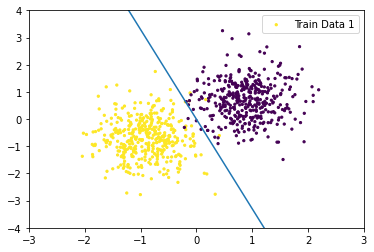

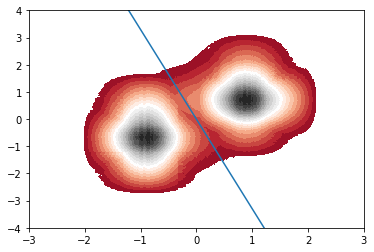

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


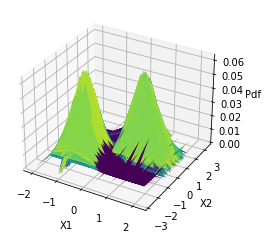

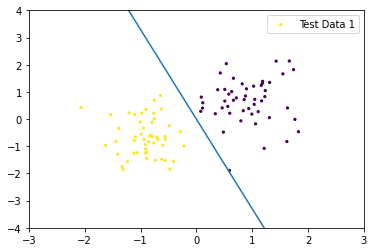

------------------------------------------------------------
--------------------------DataSet2--------------------------
Train Accuracy =  0.99125
Test Accuracy =  1.0


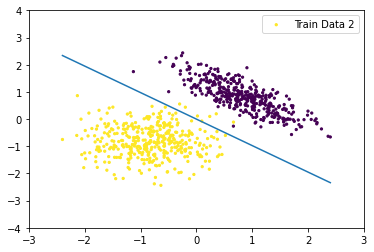

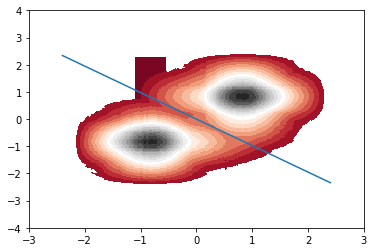

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


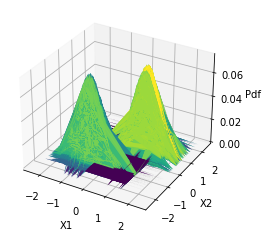

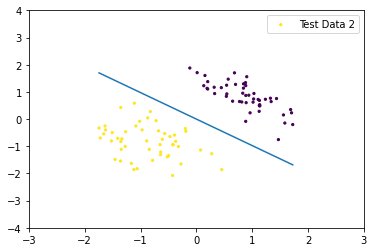

------------------------------------------------------------


In [8]:
def GLDA():
    #--------------------------------DataSet1----------------------------------#
    #-----------------LoadData-----------------#    
    x, y, m, k = load_data('Train1')
    xtest, ytest, mtest, ktest = load_data('Test1')
    #-----------------Learning-----------------#
    fi, mu, cov = glda_learn(x, y, m, k)
    a1, a2, b = calc_decision_boundary(fi, mu, cov)
    #-----------------Predict------------------#
    pyx_train, y_pred_train = predict(fi, mu, cov, x, m, k)    
    pyx_test, y_pred_test  = predict(fi, mu, cov, xtest, mtest, ktest)
    #-----------------Results------------------#
    train_accuracy = accuracy_score(y, y_pred_train)
    test_accuracy = accuracy_score(ytest, y_pred_test)
    print('--------------------------DataSet1--------------------------')
    print('Train Accuracy = ',train_accuracy)
    print('Test Accuracy = ',test_accuracy)
    #------------------plots-------------------#
    plot_scatter(x, y, 'Train Data 1')
    draw_decision_boundary(a1, a2, b, x)
    plot_pdf_contour(x,pyx_train)
    draw_decision_boundary(a1, a2, b, x)
    plot_pdf_3d(x, pyx_train)
    plot_scatter(xtest, ytest, 'Test Data 1')
    draw_decision_boundary(a1, a2, b, xtest)
    print('------------------------------------------------------------')
    #--------------------------------------------------------------------------#
    
    #--------------------------------DataSet2----------------------------------#
    #-----------------LoadData-----------------#    
    x, y, m, k = load_data('Train2')
    xtest, ytest, mtest, ktest = load_data('Test2')
    #-----------------Learning-----------------#
    fi, mu, cov = glda_learn(x, y, m, k)
    a1, a2, b = calc_decision_boundary(fi, mu, cov)
    #-----------------Predict------------------#
    pyx_train, y_pred_train = predict(fi, mu, cov, x, m, k)    
    pyx_test, y_pred_test  = predict(fi, mu, cov, xtest, mtest, ktest)
    #-----------------Results------------------#
    train_accuracy = accuracy_score(y, y_pred_train)
    test_accuracy = accuracy_score(ytest, y_pred_test)
    print('--------------------------DataSet2--------------------------')
    print('Train Accuracy = ',train_accuracy)
    print('Test Accuracy = ',test_accuracy)
    #------------------plots-------------------#
    plot_scatter(x, y, 'Train Data 2')
    draw_decision_boundary(a1, a2, b, x)
    plot_pdf_contour(x,pyx_train)
    draw_decision_boundary(a1, a2, b, x)
    plot_pdf_3d(x, pyx_train)
    plot_scatter(xtest, ytest, 'Test Data 2')
    draw_decision_boundary(a1, a2, b, xtest)
    print('------------------------------------------------------------')
    #--------------------------------------------------------------------------#


GLDA()